In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

Series_Title (Título da Série/Filme): O nome do filme ou série.  
Released_Year (Ano de Lançamento): O ano em que o filme ou série foi lançado.  
Certificate (Classificação Indicativa): A classificação indicativa do conteúdo (por exemplo, "A" pode significar adequado para todos, dependendo da região, ou algo como "R" para Restrito em outros sistemas).  
Runtime (Duração): O tempo de duração do filme ou episódio da série, geralmente em minutos.  
Genre (Gênero): O gênero cinematográfico do título (ex: Crime, Drama, Ação, Comédia).  
IMDB_Rating (Avaliação do IMDB): A nota média do filme ou série no site IMDb, dada pelos usuários.  
Overview (Sinopse/Visão Geral): Uma breve descrição ou resumo da trama do filme/série.  
Meta_score (Pontuação Metacritic): A pontuação agregada do filme ou série no site Metacritic, que reúne avaliações de críticos profissionais.  
Director (Diretor): O nome do diretor ou diretores responsáveis pelo filme/série.  
Star1, Star2, Star3, Star4 (Ator/Atriz Principal 1, 2, 3, 4): Os nomes dos principais atores ou atrizes que participaram do elenco.  
No_of_Votes (Número de Votos): O total de votos que o filme ou série recebeu no IMDb.  
Gross: Faturamento 

# análise exploratória dos dados (EDA) - Questão 1

In [2]:
df = pd.read_csv('desafio_indicium_imdb.csv')
df.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)

In [3]:
df.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [4]:
df.isnull().sum()

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    object 
 2   Certificate    713 non-null    object 
 3   Runtime        713 non-null    object 
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 89.1+ KB


In [7]:
# Quantos filmes unicos temos no dataset?
np.unique(df["Series_Title"]).shape

(713,)

In [8]:
df = df[df['Released_Year'] != 'PG']

In [9]:
# Qual mais antigo e mais recente?
df["Released_Year"].min(), df["Released_Year"].max()

('1930', '2019')

In [10]:
# Converte para número, valores inválidos viram NaN
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')

In [11]:
df.isna().sum()

Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64

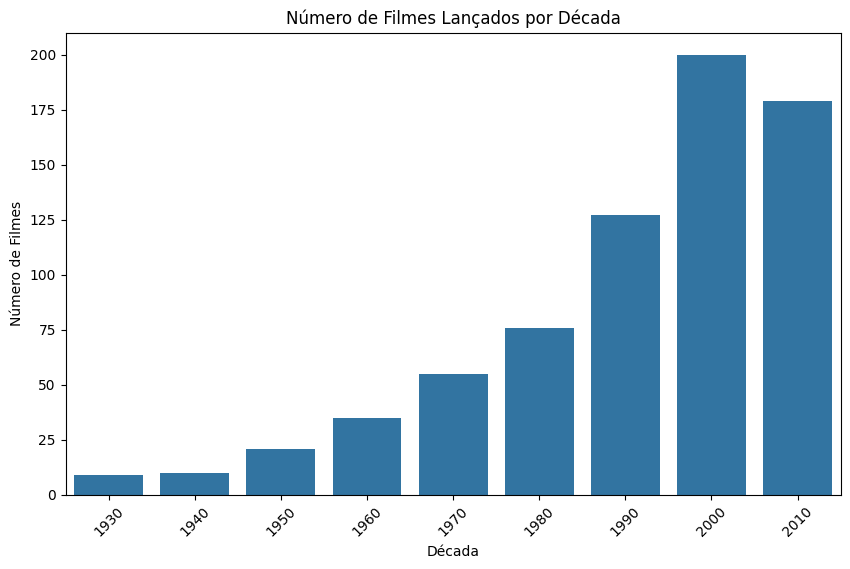

In [12]:
# Graifo de lançamentos de filme por decada
df.loc[:, 'Decade'] = (df['Released_Year'] // 10) * 10

decade_counts = df['Decade'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=decade_counts.index, y=decade_counts.values)
plt.title('Número de Filmes Lançados por Década')
plt.xlabel('Década')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.show()

In [13]:
df.drop(labels = ["Decade"], axis = 1, inplace = True)

In [14]:
# Classificação dos filmes mais comuns
df['Certificate'].value_counts()

Certificate
U           182
A           173
UA          142
R           131
PG-13        38
PG           19
G             9
Passed        9
Approved      6
TV-PG         1
U/A           1
GP            1
Name: count, dtype: int64

In [15]:
# Agrupando avaliação por certificado
certificate_ratings = df.groupby('Certificate')['IMDB_Rating'].mean().sort_values(ascending=False)
certificate_ratings

Certificate
Passed      8.044444
G           8.022222
Approved    8.016667
TV-PG       8.000000
A           7.993642
U           7.960989
UA          7.929577
PG          7.905263
R           7.866412
PG-13       7.784211
GP          7.600000
U/A         7.600000
Name: IMDB_Rating, dtype: float64

In [16]:
def modifies_runtime(runtime_str):
    runtime_str = runtime_str.lower()
    
    runtime_str = re.sub(r'[^0-9]', '', runtime_str)
    
    return runtime_str

In [17]:
# MOdiciando valores da coluna Runtime
df["Runtime"] = df["Runtime"].apply(modifies_runtime).astype(float)

In [18]:
# Media de duração dos filmes em minutos
df["Runtime"].mean()

np.float64(123.66713483146067)

In [19]:
# Minima e maxima duração dos filmes em minutos
df["Runtime"].min(), df["Runtime"].max()

(np.float64(72.0), np.float64(238.0))

In [20]:
# Generos mais populares
df['Genre'].value_counts().head(10)

Genre
Drama                           57
Drama, Romance                  26
Comedy, Drama                   24
Crime, Drama, Thriller          22
Action, Adventure, Sci-Fi       21
Biography, Drama, History       20
Animation, Adventure, Comedy    20
Crime, Drama                    19
Comedy, Drama, Romance          19
Crime, Drama, Mystery           18
Name: count, dtype: int64

In [21]:
# Minima e maxima nota IMDB
df["IMDB_Rating"].min(), df["IMDB_Rating"].max()

(np.float64(7.6), np.float64(9.2))

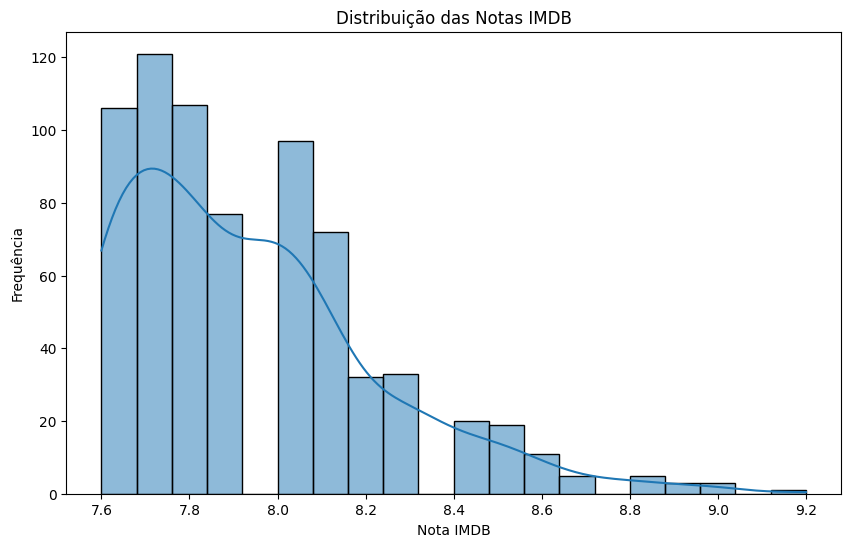

In [22]:
# Distribuição das notas IMDB
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDB_Rating'], bins=20, kde=True)
plt.title('Distribuição das Notas IMDB')
plt.xlabel('Nota IMDB')
plt.ylabel('Frequência')
plt.show()

In [23]:
# Quais atores aparecem mais frequentemente?
from collections import Counter
actor_list = df['Star1'].tolist() + df['Star2'].tolist() + df['Star3'].tolist() + df['Star4'].tolist()
actor_counts = Counter(actor_list)
actor_counts.most_common(10)

[('Robert De Niro', 16),
 ('Al Pacino', 13),
 ('Tom Hanks', 13),
 ('Brad Pitt', 12),
 ('Christian Bale', 11),
 ('Leonardo DiCaprio', 11),
 ('Clint Eastwood', 11),
 ('Matt Damon', 11),
 ('Ethan Hawke', 9),
 ('Johnny Depp', 9)]

In [24]:
# Qual diretor mais frequente?
direct_counts = df["Director"].value_counts()
direct_counts.head(10)

Director
Steven Spielberg     13
Martin Scorsese      10
Alfred Hitchcock      9
David Fincher         8
Clint Eastwood        8
Christopher Nolan     8
Quentin Tarantino     8
Woody Allen           7
Rob Reiner            7
Hayao Miyazaki        7
Name: count, dtype: int64

In [25]:
# Minima e maxima número de votos
df["No_of_Votes"].min(), df["No_of_Votes"].max()

(np.int64(25229), np.int64(2303232))

In [26]:
# Média do número de votos
df["No_of_Votes"].mean()

np.float64(353466.231741573)

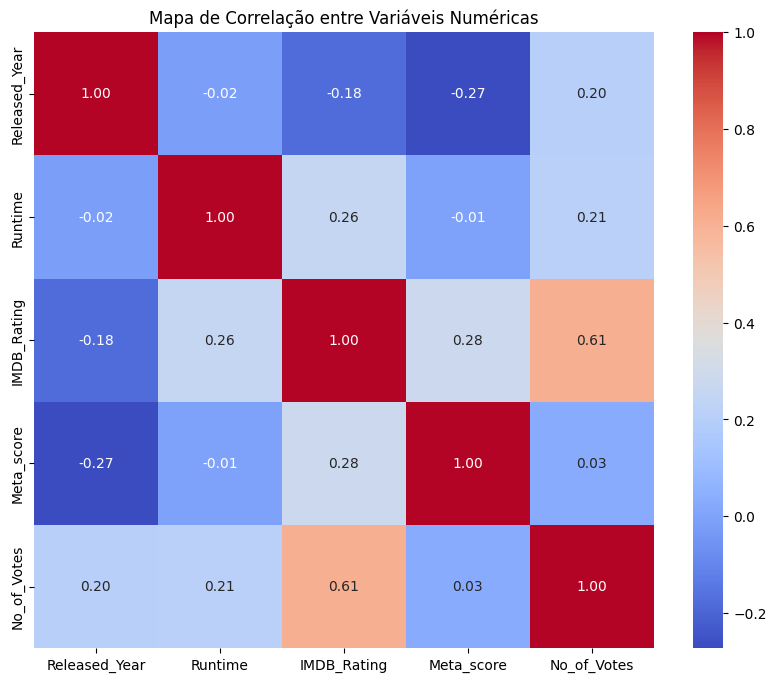

In [27]:
# Correlação entre colunas do dataset
df_numerico = df.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
sns.heatmap(df_numerico.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Correlação entre Variáveis Numéricas")
plt.show()

In [28]:
# Codigo para a resposta da terceira questão
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X = tfidf.fit_transform(df["Overview"].fillna(""))

y = df["Genre"].str.split(",").str[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

model = LogisticRegression(class_weight = "balanced",max_iter = 1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

      Action       0.40      0.52      0.45        27
   Adventure       0.11      0.12      0.12         8
   Animation       0.30      0.23      0.26        13
   Biography       0.32      0.55      0.40        11
      Comedy       0.29      0.21      0.24        24
       Crime       0.31      0.25      0.28        20
       Drama       0.35      0.37      0.36        35
      Family       0.00      0.00      0.00         1
     Mystery       0.00      0.00      0.00         3
     Western       0.00      0.00      0.00         1

    accuracy                           0.33       143
   macro avg       0.21      0.22      0.21       143
weighted avg       0.31      0.33      0.31       143



In [29]:
# Codigo para a resposta da primeira questão

# Criando dataframe como title e imdb com valores decrescentes
df_recommend = df[["Series_Title", "IMDB_Rating"]].sort_values
df_recommend

<bound method DataFrame.sort_values of                                       Series_Title  IMDB_Rating
0                                    The Godfather          9.2
1                                  The Dark Knight          9.0
2                           The Godfather: Part II          9.0
3                                     12 Angry Men          9.0
4    The Lord of the Rings: The Return of the King          8.9
..                                             ...          ...
989                                   Giù la testa          7.6
990                                 Kelly's Heroes          7.6
991                                The Jungle Book          7.6
993                             A Hard Day's Night          7.6
996                          From Here to Eternity          7.6

[712 rows x 2 columns]>

In [30]:
# Codigo para a resposta da segunda questão

actors = pd.melt(
    df,
    id_vars=['Gross'],
    value_vars=['Star1', 'Star2', 'Star3', 'Star4'],
    value_name='Actor'
)

In [31]:
# Codigo para a resposta da segunda questão

actors = actors.dropna(subset=["Actor"])
actors["Gross"] = (actors["Gross"]).replace("[\$,]", "", regex=True).astype(float)
actors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Gross     2848 non-null   float64
 1   variable  2848 non-null   object 
 2   Actor     2848 non-null   object 
dtypes: float64(1), object(2)
memory usage: 66.9+ KB


In [32]:
# Codigo para a resposta da segunda questão

actor_gross = actors.groupby("Actor")["Gross"].mean().sort_values(ascending=False)
print(actor_gross.head(10))

Actor
John Boyega           9.366622e+08
Daisy Ridley          9.366622e+08
Michelle Rodriguez    7.605076e+08
Billy Zane            6.593254e+08
Huck Milner           6.085817e+08
Sarah Vowell          6.085817e+08
Joe Russo             5.512599e+08
Aaron Eckhart         5.348584e+08
Diego Luna            5.321773e+08
Donnie Yen            5.321773e+08
Name: Gross, dtype: float64


**Resultado do EDA**
Total de títulos após limpeza: 713 itens.  
Período coberto: 1930 a 2019.  
Certificados mais comuns: U, A, UA e R.  
Gêneros mais frequentes:
- Drama  
- Drama e Romance  
- Comedy e Drama  
-  Crime, Drama e Thriller  
- Action, Adventure e Sci-Fi

Duração média dos filmes: 123,7 minutos.  
Atores mais recorrentes: Robert De Niro, Al Pacino, Tom Hanks, Brad Pitt, Christian Bale.  
Diretores mais recorrentes: Steven Spielberg, Martin Scorsese, Alfred Hitchcock, David Fincher, Clint Eastwood.  

## Perguntas e Respostas - Questão 2

a. **Qual filme você recomendaria para uma pessoa que você não conhece:**  

Eu recomendaria filmes baseados na notas IMDB que seria algo the The Lord of the Rings: The Return of the King e The Godfather

b. **Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?**  

Observa-se que filmes com a participação de atores como John Boyega, Daisy Ridley e Michelle Rodriguez tendem a ter bilheteria mais alta.

c. **Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?**  

**Informação textual é limitada para classes pequenas** 

*   Classes como Family, Mystery, Western não foram previstas pelo modelo.
*   Isso indica que as sinopses desses filmes são muito raras ou genéricas para o modelo identificar padrões distintos.

**Palavras-chave podem indicar gênero**

*  Para gêneros mais frequentes (Action, Drama, Biography), o modelo consegue capturar algumas pistas do texto, como termos relacionados a ação, conflito, vida real, etc.
*   Isso mostra que a coluna Overview tem potencial para indicar o gênero, mas precisa de técnicas melhores de NLP.

A coluna Overview tem potencial para prever gênero, mas é insuficiente por si só com técnicas básicas.

Para gerar insights mais confiáveis, é necessário tratar desequilíbrio de classes, usar embeddings e modelos de NLP mais avançados, além de explorar métricas de avaliação que considerem classes raras.

# Treinamento de Modelo

In [33]:
df.drop(labels = ["Series_Title", "Overview"], axis = 1, inplace = True)

In [34]:
df.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1972,A,175.0,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2008,UA,152.0,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,1974,A,202.0,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,1957,U,96.0,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,2003,U,201.0,"Action, Adventure, Drama",8.9,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [35]:
# Remover vírgulas e converter para float

df['Gross'] = df['Gross'].str.replace(',', '').astype(float)

In [36]:
X = df.drop(columns = ["IMDB_Rating"])

categorical_cols = ["Certificate", "Genre", "Director", "Star1", "Star2", "Star3", "Star4"]
numeric_cols = ["Released_Year", "Runtime", "Meta_score", "No_of_Votes", "Gross"]

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)

In [37]:
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(feature_names) + numeric_cols

In [38]:
X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed, columns = all_feature_names)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, df["IMDB_Rating"], test_size = 0.2, random_state = 1)

In [40]:
X_train.shape, X_test.shape

((569, 2953), (143, 2953))

## Tuning de parâmetros

### Decision Tree Regressor

In [41]:
params_dt = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "splitter": ["best", "random"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_depth": [None, 5, 10, 20]
}

In [ ]:
grid_search = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = params_dt)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_result = grid_search.best_score_
print(best_params, best_result)

Melhores parametros  
Criterion: friedman_mse  
max_depth: 5  
min_samples_leaf: 5  
min_samples_split: 5  
splitter: random  

### Random Forest Regressor

In [ ]:
params_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = params_rf)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_result = grid_search.best_score_
print(best_params, best_result)

Melhores paramatros  
Max_depth: 10  
Min_samples_leaf: 2  
min_samples_split: 2  
n_estimators: 200  

### Gradient Boosting Regressor

In [ ]:
params_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 5]
}

grid_search = GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = params_gb)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_result = grid_search.best_score_
print(best_params, best_result)

Melhores parametros  
learning_rate: 0.1  
max_depth: 3  
min_samples_leaf: 5  
min_samples_split: 2  
n_estimators: 100  

## Validação cruzada

In [ ]:
resuls_tree = []
results_forest = []
results_boosting = []

for i in range(30):
    kfold = KFold(n_splits = 10, shuffle = True, random_state = 1)
    tree = DecisionTreeRegressor(criterion = "squared_error", max_depth = 5, min_samples_leaf = 5, min_samples_split = 5, splitter= "best")
    scores = cross_val_score(tree, X_train, y_train, cv = kfold)
    resuls_tree.append(scores.mean())
    
    random_forest = RandomForestRegressor(max_depth = 10, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 300)
    scores = cross_val_score(random_forest, X_train, y_train, cv = kfold)
    results_forest.append(scores.mean())
    
    boosting = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, min_samples_leaf = 5, min_samples_split = 2, n_estimators = 100)
    scores = cross_val_score(boosting, X_train, y_train, cv = kfold)
    results_boosting.append(scores.mean())

In [ ]:
results = pd.DataFrame({
    "Decision Tree": resuls_tree,
    "Random Forest": results_forest,
    "Gradient Boosting": results_boosting
})
results.describe()

,Decision Tree,Random Forest,Gradient Boosting
count,10.000000,10.000000,10.000000
mean,0.390894,0.572362,0.578581
std,0.002783,0.001637,0.000058
min,0.386480,0.568713,0.578506
25%,0.390770,0.571592,0.578522
50%,0.391310,0.572878,0.578582
75%,0.391851,0.573314,0.578640
max,0.396140,0.574215,0.578640


In [43]:
boosting = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, min_samples_leaf = 5, min_samples_split = 2, n_estimators = 100)
boosting.fit(X_train, y_train)
y_pred = boosting.predict(X_test)

In [44]:
mean_squared_error(y_test, y_pred)

0.04186552347056919

# Perguntas e respostas - Questão 3

a.	**Explique como você faria a previsão da nota do imdb a partir dos dados.**   

Primeiro, identifiquei a variável alvo, que neste caso é IMDB_Rating, e em seguida selecionei as variáveis preditivas, correspondentes às demais colunas, excluindo Series_Title e Sinopse, pois considerei que poderiam atrapalhar o desempenho do modelo.  

No passo anterior, tratei os valores faltantes removendo-os do dataset, portanto não foi necessário aplicar outro tipo de imputação. Transformei variáveis do tipo object em float para facilitar o processamento pelo modelo e realizei o tratamento das variáveis categóricas utilizando OneHotEncoder.  

Inicialmente, apliquei escalonamento nos dados numéricos, mas isso resultou em uma queda significativa na acurácia do modelo, então decidi reverter essa etapa.  

b. **Quais variáveis e/ou suas transformações você utilizou e por quê?**  

Utilizei todas as colunas como variáveis preditivas, exceto Series_Title e Overview, pois considerei que poderiam prejudicar o desempenho do modelo. Além disso, realizei a transformação OneHotEncoder nas colunas categóricas para convertê-las em formato numérico, permitindo que o modelo as interpretasse corretamente.  

c. **Qual tipo de problema estamos resolvendo (regressão, classificação)?**  

O problema que estou resolvendo é de regressão, pois o objetivo é prever um valor contínuo, que no meu caso é o IMDB_Rating.

d. **Qual modelo melhor se aproxima dos dados e quais seus prós e contras?**  

O modelo que melhor se aproxima dos dados é o Gradient Boosting, pois apresenta a maior média de acurácia/score (0.578581) e a menor variação (std = 0.000058), indicando previsões mais consistentes.  

Prós: Alta precisão, bom para dados complexos, lida bem com interações entre variáveis.  
Contras: Mais lento para treinar, sensível a hyperparâmetros, risco de overfitting se não regulado.

e. **Qual medida de performance do modelo foi escolhida e por quê?**  

A medida de performance escolhida foi o Mean Squared Error (MSE), que calcula a média dos erros ao quadrado entre os valores previstos e os valores reais. Essa métrica foi escolhida porque é adequada para problemas de regressão, penaliza mais fortemente grandes erros e permite avaliar com clareza o quão próximo o modelo está das previsões corretas. Quanto menor o MSE, melhor o desempenho do modelo.

 4. Supondo um filme com as seguintes características:

 new_movie = {  
    'Series_Title': 'The Shawshank Redemption',  
    'Released_Year': 1994,  
    'Certificate': 'A',  
    'Runtime': '142 min',  
    'Genre': 'Drama',  
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',  
    'Meta_score': 80.0,  
    'Director': 'Frank Darabont',  
    'Star1': 'Tim Robbins',  
    'Star2': 'Morgan Freeman',  
    'Star3': 'Bob Gunton',  
    'Star4': 'William Sadler',  
    'No_of_Votes': 2343110,  
    'Gross': '28,341,469'  
}  
Qual seria a nota do IMDB?

In [ ]:
new_movie = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# Seguindo o mesmo fluxo que segui durante o treinamento
df_new_movie = pd.DataFrame([new_movie])
df_new_movie.drop(labels = ["Series_Title", "Overview"], axis = 1, inplace = True)
df_new_movie['Gross'] = df_new_movie['Gross'].str.replace(',', '').astype(float)
df_new_movie["Runtime"] = df_new_movie["Runtime"].apply(modifies_runtime).astype(float)
df_new_movie_transformed = preprocessor.transform(df_new_movie)
y_new_pred = boosting.predict(df_new_movie_transformed)
print(f"A previsão de IMDB Rating para o filme '{new_movie['Series_Title']}' é: {y_new_pred[0]:.2f}")

A previsão de IMDB Rating para o filme 'The Shawshank Redemption' é: 8.75


5. **Salve o modelo desenvolvido no formato .pkl.**

In [ ]:
joblib.dump(boosting, "model_boosting.pkl")

['model_boosting.pkl']